In [1]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100

targhe = [
"FY293YC", "FY295YC", "FY298YC", "FY294YC", "FY296YC", "FV903SK", "FV904SK", "FV906SK", "FV907SK", "FV908SK", "FZ330SC", "FV913SK", "FV914SK", "FY402YC", "FY403YC", "ZB477AN", "ZB473AN", "ZB474AN", "ZB476AN", "ZB475AN", "ZB478AN", "ZB137AR", "ZB139AR", "ZB150AR", "ZB127AR", "ZB132AR", "ZB128AR", "ZB131AR", "ZB130AR", "FY400YC", "ZB135AR", "ZB136AR", "ZB134AR", "ZB373AN", "FY401YC", "CW363HC", "CW367HC", "FP698BP", "FP699BP", "CW365HC", "CW368HC", "CN433CA", "FV989FV", "FV990FV", "FV991FV", "FV995FV", "FV996FV", "FV997FV", "FV992FV", "FV985FV", "FV987FV", "FV988FV", "FV993FV", "FV994FV", "EG181YE", "FV986FV", "EN971TN", "FY299YC", 
]
sns.set_style("whitegrid")

%matplotlib inline

Excel files can be downloaded
 - Veicoli: [[here](https://docs.google.com/spreadsheets/d/1KoSnpYXO4Roeg1nOscIsg4m6jvHN60k2/edit?usp=sharing&ouid=100767706223000279509&rtpof=true&sd=true)]
 - Fatture: [[here](https://teams.microsoft.com/l/file/2C9DF49B-8E52-438C-BEC5-F932517E22D0?tenantId=2a05ac92-2049-4a26-9b34-897763efc8e2&fileType=xlsx&objectUrl=https%3A%2F%2Fpolitoit.sharepoint.com%2Fteams%2FR-GRP_AI4Trucks%2FShared%20Documents%2FGeneral%2FAnalisi%2Feventi_manutenzioni_esterne%20(da%20fatture).xlsx&baseUrl=https%3A%2F%2Fpolitoit.sharepoint.com%2Fteams%2FR-GRP_AI4Trucks&serviceName=teams&threadId=19:uchivw6_oRyy6ipbNZlMKqkJWjGS5PxW2PGkqRwyvPE1@thread.tacv2&groupId=540e54c7-2583-4176-bcda-2ca674542369)]

In [96]:
veicoli = pd.read_excel("excels/SEA_Flotta_Elenco_Veicoli.xlsx", skiprows=lambda x: x > 341) # il file contiene altre cose dopo
veicoli = veicoli.drop(veicoli.columns[-5:-2], axis=1)[veicoli.TARGA.isin(targhe)]\
          .reset_index(drop=True).rename(columns=str.title).rename(columns=str.strip)
veicoli["plate"] = veicoli.Targa

veicoli["Sistema Gps Tracking"] = veicoli["Sistema Gps Tracking"].str.replace(' ', '').str.split('+')#.unique()
veicoli = veicoli.explode("Sistema Gps Tracking").groupby(['Targa', 'Sistema Gps Tracking']).first()

fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx")
fatture.Apertura_commessa = pd.to_datetime(fatture.Apertura_commessa)

# Data cleaning - [MOVIMATICA](https://jupyter.polito.it/expert/hub/user-redirect/lab/tree/ai4Trucks/SEA%20Data%20Lake/MOVIMATICA)

In [4]:
df_MOV_vehicles = pd.read_csv("dataset/MOVIMATICA_vehicles.csv", index_col=0)
df_MOV_vehicles.position_timestamp = pd.to_datetime(df_MOV_vehicles.position_timestamp, format="%Y-%m-%dT%H:%M:%S%z", utc=True)
df_MOV_vehicles["position_date"] = df_MOV_vehicles.position_timestamp.dt.date
df_MOV_vehicles = df_MOV_vehicles[df_MOV_vehicles.plate.isin(targhe)]#.drop_duplicates().sort_values(by="position_timestamp")
df_MOV_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label,filename,position_date
0,0,NaN,0,NONE,NaN,D4257,Isuzu,TIS213369/18,NaN,4514,0,NaN,False,7425,True,False,disabled,M21,Isuzu M21,30349,ZB478AN,45.960472,8.421074,1060885110,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,12,2021-05-11 07:34:28+00:00,digital_input_change,Cambio Digital IN,TIS213369/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
1,0,NaN,0,NONE,NaN,D4324,Isuzu,TIS283444/18,NaN,4426,0,NaN,False,7428,True,False,disabled,M21,Isuzu M21,37532,ZB476AN,45.960022,8.420602,1061115070,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-05-11 09:26:41+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
2,0,NaN,0,NONE,NaN,D4314,Isuzu,TIS213368/18,NaN,3497,0,NaN,False,7430,True,False,disabled,M21,Isuzu M21,24933,ZB477AN,41.784200,12.301565,1061114233,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,1,2021-05-11 09:20:15+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
3,0,NaN,0,NONE,NaN,D6190,Isuzu,TIS433613/18,NaN,1395,0,NaN,False,9606,True,False,disabled,P75,Isuzu P75,63197,ZB127AR,44.585390,7.902978,1061318067,False,Località Piano 5,IT,Italia,Novello,Piemonte,12060.0,0,2021-05-11 10:40:38+00:00,external_power_on,Alimentazione ripristinata,TIS433613/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
6,0,NaN,0,NONE,NaN,D6220,Scania,TIMP44648/18,NaN,959,0,NaN,False,9741,True,False,disabled,P320,Scania P320,11308,FV914SK,45.947212,10.905164,1061560745,False,Località Matoni 1,IT,Italia,Dro,Trentino-Alto Adige,38074.0,1,2021-05-11 13:08:58+00:00,external_power_on,Alimentazione ripristinata,TIMP44648/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11


## Check ripetizioni

In [4]:
important = df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.date<pd.Timestamp("2021-09-01")]
gpb = important.groupby(["plate", "position_timestamp"]).sav.count()
anom_plates = gpb[gpb>20].index.get_level_values(0).unique()
anom_date = gpb.reset_index().groupby("plate").position_timestamp.first()

/home/students/s265780/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [6]:
check = []
for pl, g in important[important.plate.isin(anom_plates)].groupby(["plate"]):
    date_after = g[g.position_timestamp > anom_date[pl]].position_timestamp.min()
    check.append([
        pl,
        anom_date[pl],
        g[g.position_timestamp == anom_date[pl]].odometer.min(),
        date_after,
        g[g.position_timestamp == date_after].odometer.min()
    ])
    
Anomalies = pd.DataFrame(check, columns=["plate", "an_date", "km_an", "date_after", "km_after"])

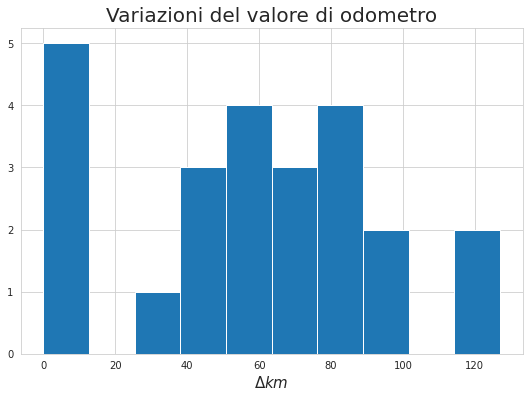

In [62]:
Anomalies["delta_date"] = Anomalies.date_after - Anomalies.an_date
Anomalies["delta_km"] = Anomalies.km_after - Anomalies.km_an
ax = Anomalies[["delta_date", "delta_km"]].delta_km.hist(figsize=(9,6))
ax.set_xlabel("$\Delta km$", size=15)
ax.set_title("Variazioni del valore di odometro", size=20)
plt.show()

In [8]:
df_MOV_vehicles[df_MOV_vehicles.groupby(["plate", "position_timestamp"], as_index=False).sav.transform("count")>28]

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label,filename,position_date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,TIS283439/18,NaN,NaN,NaN,NaN


In [9]:
tmp = df_MOV_vehicles[(df_MOV_vehicles.plate=="FV914SK")\
                      &(df_MOV_vehicles.position_timestamp.dt.date > pd.Timestamp("2021-07-15"))\
                      &(df_MOV_vehicles.position_timestamp.dt.date < pd.Timestamp("2021-08-01"))].reset_index(drop=True)

/home/students/s265780/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [10]:
from matplotlib import dates

No handles with labels found to put in legend.


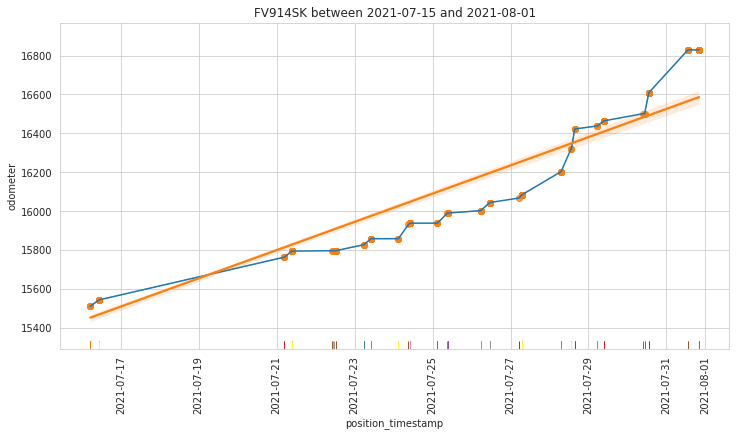

In [16]:
fig, g = plt.subplots(figsize=(12,6))

# @pyplot.FuncFormatter
# def fake_dates(x, pos):
#     """ Custom formater to turn floats into e.g., 2016-05-08"""
#     return dates.num2date(x).strftime('%Y-%m-%d')

sns.lineplot(data=tmp, x="position_timestamp", y="odometer", ax=g)
sns.regplot(data=tmp, x=dates.date2num(tmp.position_timestamp), y="odometer", ax=g)
# sns.lineplot(data=tmp, x="position_timestamp", y="engineHours", ax=g, color="violet")
g.set_title("FV914SK between 2021-07-15 and 2021-08-01")
sns.rugplot(data=tmp, x="position_timestamp", hue="filename", ax=g, legend=False, palette="Set1")
g.legend().remove()
g.tick_params(axis='x', rotation=90)

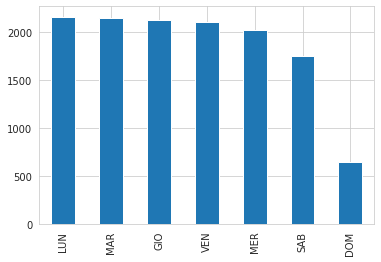

In [186]:
df_MOV_vehicles.position_timestamp.dt.dayofweek.value_counts().rename({
    0: "LUN",
    1: "MAR",
    2: "MER",
    3: "GIO",
    4: "VEN",
    5: "SAB",
    6: "DOM"
}).plot(kind="bar")
plt.show()

---
## Overview

In [37]:
date_range = (df_MOV_vehicles.position_date.max() - df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.year==2021].position_date.min()).days
targhe_here = df_MOV_vehicles.plate.unique()

print(f"Dati raccolti tra {df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.year==2021].position_date.min().strftime('%m/%Y')} e {df_MOV_vehicles.position_date.max().strftime('%m/%Y')} (con alcune eccezioni)\n\
{df_MOV_vehicles.shape[1]} parametri totali monitorati\n\
{df_MOV_vehicles.shape[0]} record nel datalake\n\
{df_MOV_vehicles.drop('filename', axis=1).drop_duplicates().shape[0]} record non ripetuti\n\
{len(targhe_here)} truck monitorati\n\
In media {df_MOV_vehicles.shape[0]/len(targhe_here)} misurazioni per ogni mezzo su 5 mesi\n\
In media {df_MOV_vehicles.shape[0]/len(targhe_here)/date_range} misurazioni/giorno/mezzo (dettaglio successivamente)\n\
{len(fatture[fatture.Targa.isin(df_MOV_vehicles.plate.unique())])} fatture associate.")

Dati raccolti tra 05/2021 e 09/2021 (con alcune eccezioni)
40 parametri totali monitorati
60480 records nel datalake
12964 records non ripetuti
35 truck monitorati
In media 1728.0 misurazioni per ogni mezzo su 5 mesi
In media 12.8 misurazioni/giorno/mezzo (dettaglio successivamente)
285 fatture associate.


In [49]:
tmp = df_MOV_vehicles.isna().sum()
tmp[tmp>0]

alarm_name              60429
alarm_tipology_label    60480
customId                60480
fleet_ilabel            60480
dtype: int64

In [50]:
useless_cols = [c for c in df_MOV_vehicles.columns if len(df_MOV_vehicles[c].unique()) == 1]
print(df_MOV_vehicles[useless_cols].iloc[0,:])

df_MOV_vehicles = df_MOV_vehicles.drop(useless_cols, axis=1)

alarm_tipology_label                     NaN
customId                                 NaN
fleet_id                                   0
fleet_ilabel                             NaN
hasTelemetry                           False
lock_enabled                            True
lock_locked                            False
lock_status                         disabled
position_place_country_id                 IT
position_place_country_label          Italia
typology_id                        COMPACTOR
typology_label                  Compattatore
Name: 0, dtype: object


In [98]:
fatture.head()

,ID,Targa,Telaio,Tipo_veicolo,Km,Apertura_commessa,Anno,Importo,Tipo_manutenzione,Manutenzione_struttura,Descrizione,Commenti
0,1,ZB134AR,JAANPR85HJ7100338,Mini_compattatore,3256.0,2019-09-16,2019,55.51,Ordinaria,Telaio,NaN,NaN
1,2,FV996FV,ZAPS90AGW00002639,Vasca,12767.0,2019-09-18,2019,163.31,Ordinaria,Telaio,NaN,NaN
2,3,FV997FV,ZAPS90AGW00002647,Vasca,9054.0,2019-09-18,2019,141.42,Ordinaria,Telaio,NaN,NaN
3,4,ZB150AR,JAANLR87EH7102953,Mini_compattatore,21117.0,2019-09-18,2019,171.20,Ordinaria,Telaio,NaN,NaN
4,5,EN971TN,ZAPS90CJW00001299,Vasca,115498.0,2019-09-19,2019,221.42,Ordinaria,Telaio,NaN,NaN


In [130]:
report = df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.year == 2021].groupby('plate').agg({
    "position_timestamp": ["min", "max", "count", pd.Series.nunique],
}).droplevel(0, axis=1)

report["fatture"] = report.apply(lambda x: fatture[(fatture.Targa==x.name)&(fatture.Apertura_commessa.dt.date>=x['min'].date())&(fatture.Apertura_commessa.dt.date<=x['max'].date())].ID.count(), axis=1)
report = report.reset_index().rename(columns={
    'count': 'n_samples',
    'nunique': 'distinct',
})

In [131]:
report.head()

,plate,min,max,n_samples,distinct,fatture
0,FV903SK,2021-05-11 11:16:09+00:00,2021-09-22 09:44:57+00:00,1728,366,3
1,FV904SK,2021-05-11 10:09:37+00:00,2021-09-22 10:06:35+00:00,1728,359,0
2,FV906SK,2021-05-11 09:42:29+00:00,2021-09-22 10:02:04+00:00,1728,340,0
3,FV907SK,2021-05-11 15:08:29+00:00,2021-09-22 10:57:22+00:00,1728,324,6
4,FV908SK,2021-05-11 09:40:43+00:00,2021-09-22 12:13:20+00:00,1728,396,5


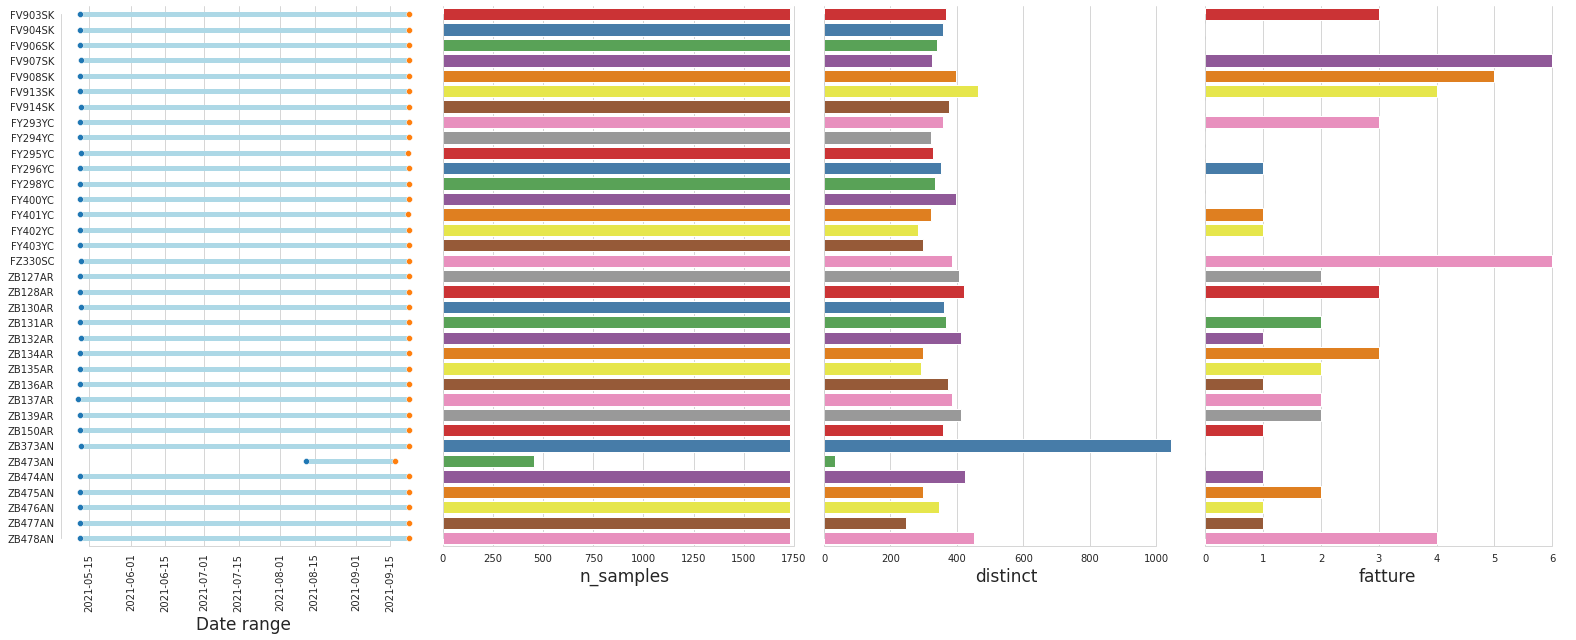

In [209]:
fig, ax = plt.subplots(1,4, figsize=(22,9), sharey=True)
sns.scatterplot(data=report, x="min", y="plate", palette='Set1', ax=ax[0], zorder=4)
sns.scatterplot(data=report, x="max", y="plate", palette='Set1', ax=ax[0], zorder=4)
ax[0].hlines(data=report, y="plate", xmin="min", xmax="max", linewidth=5, color='lightblue')
sns.barplot(data=report, x="n_samples", y="plate", palette='Set1', ax=ax[1])
sns.barplot(data=report, x="distinct", y="plate", palette='Set1', ax=ax[2])
sns.barplot(data=report, x="fatture", y="plate", palette='Set1', ax=ax[3])

ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel("Date range")
for a in ax:
    a.set_ylabel("")
    a.set_xlabel(a.get_xlabel(), size=17)
#     a.grid(False)
    a.yaxis.grid(False)
    sns.despine(trim=True)
    
plt.tight_layout()

In [181]:
df_MOV_vehicles = df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.year==2021].drop('filename', axis=1).drop_duplicates()

---
## Monotonia

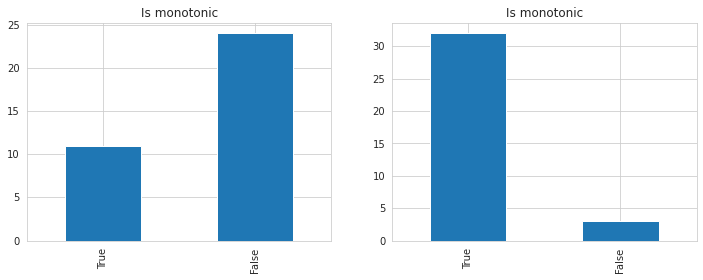

In [188]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_MOV_vehicles.groupby('plate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title="Is monotonic", ax=ax[0])
df_MOV_vehicles.groupby('plate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Is monotonic", ax=ax[1])
plt.show()

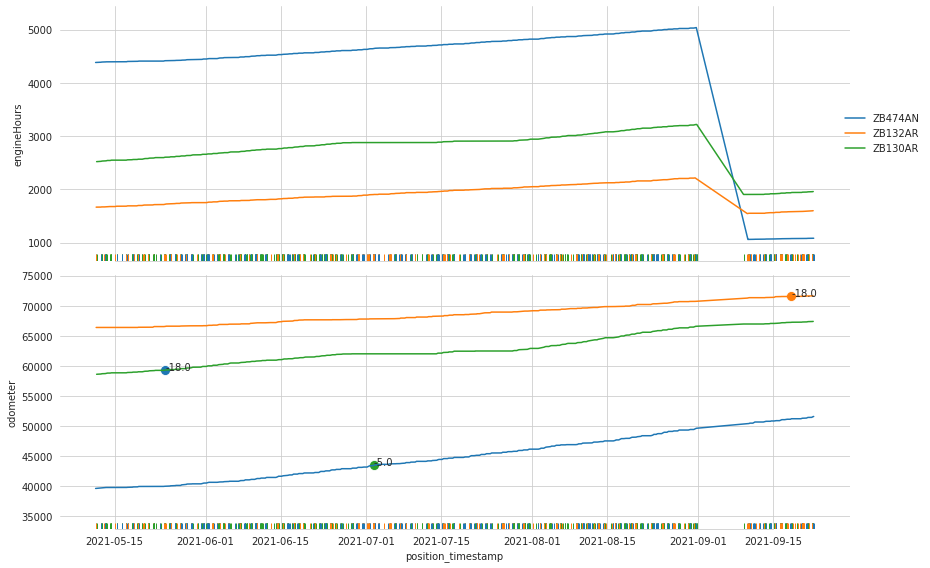

In [165]:
tmp = df_MOV_vehicles[df_MOV_vehicles.groupby('plate').odometer.transform(lambda x: not x.is_monotonic_increasing)]
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
sns.lineplot(data=tmp, x="position_timestamp", y="engineHours", hue="plate", ax=ax[0])
sns.rugplot(data=tmp, x="position_timestamp", hue="plate", ax=ax[0])

sns.lineplot(data=tmp, x="position_timestamp", y="odometer", hue="plate", ax=ax[1])
sns.rugplot(data=tmp, x="position_timestamp", hue="plate", ax=ax[1])

for i, (plate, d) in enumerate(tmp.groupby('plate')[["position_timestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="position_timestamp", y="odometer", markers="*", s=100)
    plt.text(x=d[d.df<0].position_timestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,.5))
plt.show()

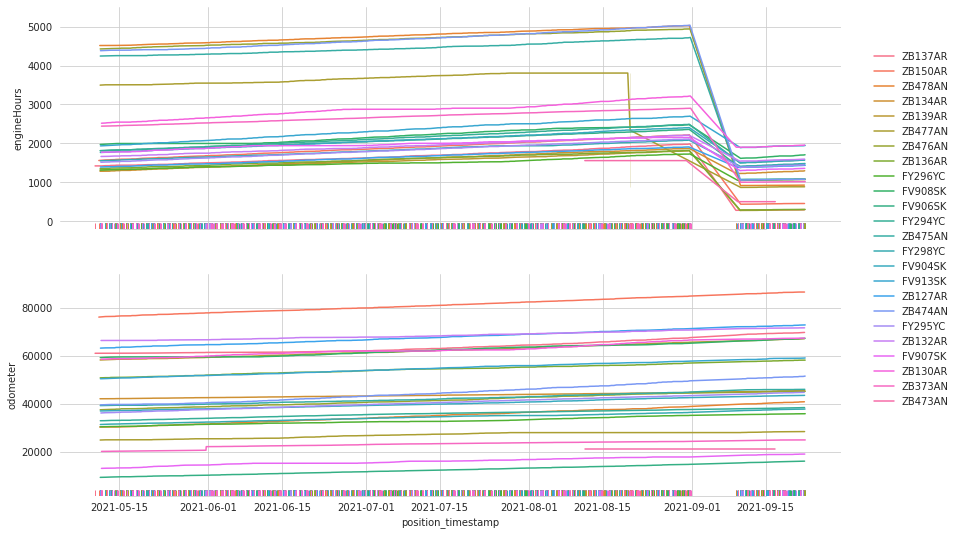

In [166]:
fig, ax = plt.subplots(2,1, figsize=(14,9), sharex=True)
tmp2 = df_MOV_vehicles[(df_MOV_vehicles.groupby('plate').engineHours.transform(lambda x: not x.is_monotonic_increasing))&(df_MOV_vehicles.position_timestamp.dt.year == 2021)]
sns.lineplot(data=tmp2, x="position_timestamp", y="engineHours", hue="plate", ax=ax[0])
sns.rugplot(data=tmp2, x="position_timestamp", hue="plate", ax=ax[0])

ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.15,0))

sns.lineplot(data=tmp2, x="position_timestamp", y="odometer", hue="plate", ax=ax[1])
sns.rugplot(data=tmp2, x="position_timestamp", hue="plate", ax=ax[1])

sns.despine(trim=True, left=True)
ax[1].get_legend().remove()
plt.show()

In [167]:
df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.date<pd.to_datetime("2021-09-01")].groupby('plate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_index(ascending=False)#.plot(kind="bar", title="Is monotonic (before 2021-09-01)")
# plt.show()

/home/students/s265780/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


True     33
False     2
Name: engineHours, dtype: int64

---
## Analisi Misurazioni giornaliere

In [184]:
view_fatture = fatture[(fatture.Targa.isin(df_MOV_vehicles.plate.unique()))&\
                       (fatture.Apertura_commessa.dt.date>=df_MOV_vehicles.position_timestamp.min().date())&\
                       (fatture.Apertura_commessa.dt.date<=df_MOV_vehicles.position_timestamp.max().date())]

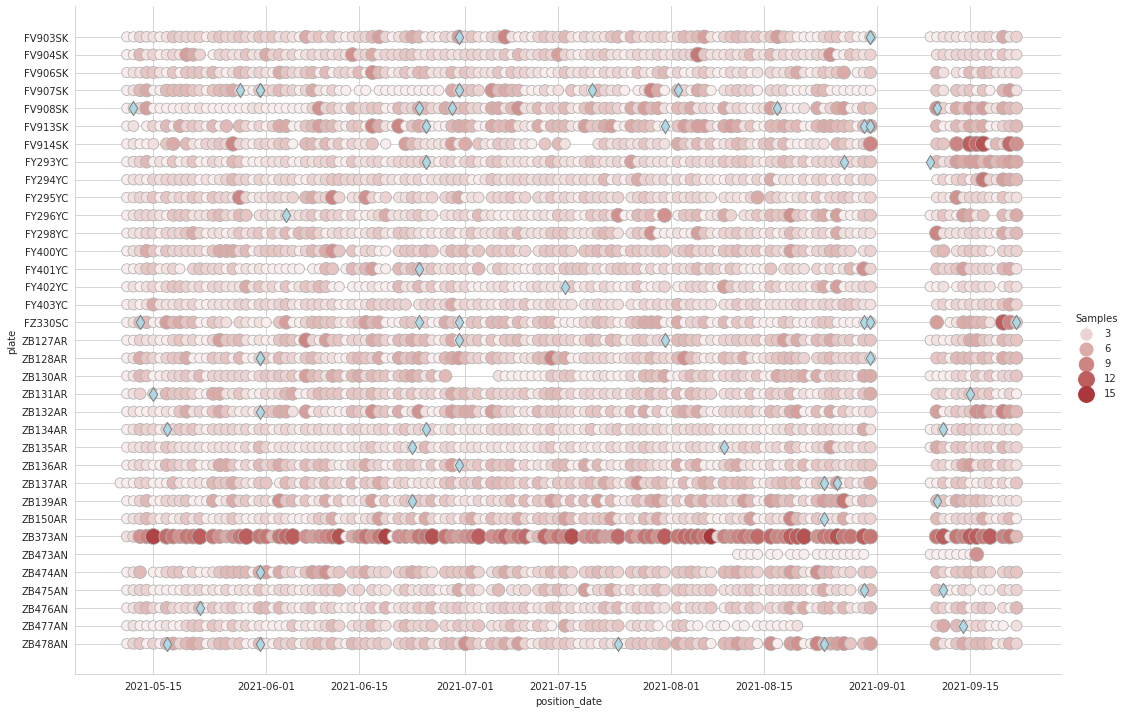

In [205]:
tmp = df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.year == 2021].sort_values(by="position_date").groupby(["plate", "position_date"], as_index=False).box.count()
tmp['c'] = tmp.box / tmp.box.max()
g = sns.relplot(
    data=tmp,
    x="position_date", y="plate", hue="c", size="c",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8), aspect=1.5
)
plt.scatter(data=view_fatture, x="Apertura_commessa", y="Targa", marker="d", s=100, c="lightblue", edgecolors="grey")

for t in g._legend.get_texts():
    t.set_text(int(float(t.get_text())*tmp.box.max()))
g._legend.set_title("Samples")

Text(0, 0.5, 'count')

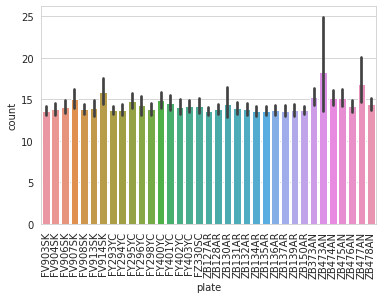

In [19]:
g = sns.barplot(data=tmp, x="plate", y="box")
g.tick_params(axis='x', rotation=90)
g.set_ylabel("count")

In [171]:
df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"].position_typology_id.value_counts().to_frame()

,position_typology_id
digital_input_change,847
motion_stop,193
position,3
external_power_on,1


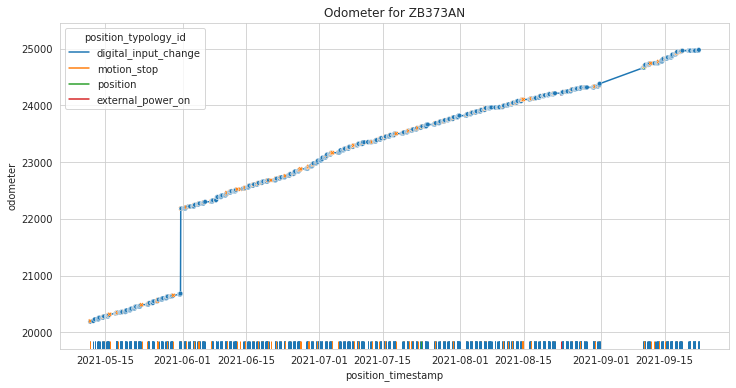

In [174]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
             x="position_timestamp",
             y="odometer",
             ax=ax
            )

sns.scatterplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
                x="position_timestamp",
                y="odometer",
                hue="position_typology_id",
                style="position_typology_id",
                ax=ax,
                zorder=4,
                s=20
               )
sns.rugplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
            x="position_timestamp",
            hue="position_typology_id"
           )
ax.set_title("Odometer for ZB373AN")
plt.show()

In [ ]:
# TO FIX!
tmp = df_MOV_vehicles.groupby(['plate', "position_date"]).engineHours.count().reset_index()
g = sns.FacetGrid(tmp, row="plate", aspect=2)
g.map(sns.barplot, "position_date", "engineHours")

---
## Correlation

In [20]:
df_MOV_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label,filename,position_date
0,0,NaN,0,NONE,NaN,D4257,Isuzu,TIS213369/18,NaN,4514,0,NaN,False,7425,True,False,disabled,M21,Isuzu M21,30349,ZB478AN,45.960472,8.421074,1060885110,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,12,2021-05-11 07:34:28+00:00,digital_input_change,Cambio Digital IN,TIS213369/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
1,0,NaN,0,NONE,NaN,D4324,Isuzu,TIS283444/18,NaN,4426,0,NaN,False,7428,True,False,disabled,M21,Isuzu M21,37532,ZB476AN,45.960022,8.420602,1061115070,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-05-11 09:26:41+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
2,0,NaN,0,NONE,NaN,D4314,Isuzu,TIS213368/18,NaN,3497,0,NaN,False,7430,True,False,disabled,M21,Isuzu M21,24933,ZB477AN,41.784200,12.301565,1061114233,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,1,2021-05-11 09:20:15+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
3,0,NaN,0,NONE,NaN,D6190,Isuzu,TIS433613/18,NaN,1395,0,NaN,False,9606,True,False,disabled,P75,Isuzu P75,63197,ZB127AR,44.585390,7.902978,1061318067,False,Località Piano 5,IT,Italia,Novello,Piemonte,12060.0,0,2021-05-11 10:40:38+00:00,external_power_on,Alimentazione ripristinata,TIS433613/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
6,0,NaN,0,NONE,NaN,D6220,Scania,TIMP44648/18,NaN,959,0,NaN,False,9741,True,False,disabled,P320,Scania P320,11308,FV914SK,45.947212,10.905164,1061560745,False,Località Matoni 1,IT,Italia,Dro,Trentino-Alto Adige,38074.0,1,2021-05-11 13:08:58+00:00,external_power_on,Alimentazione ripristinata,TIMP44648/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11


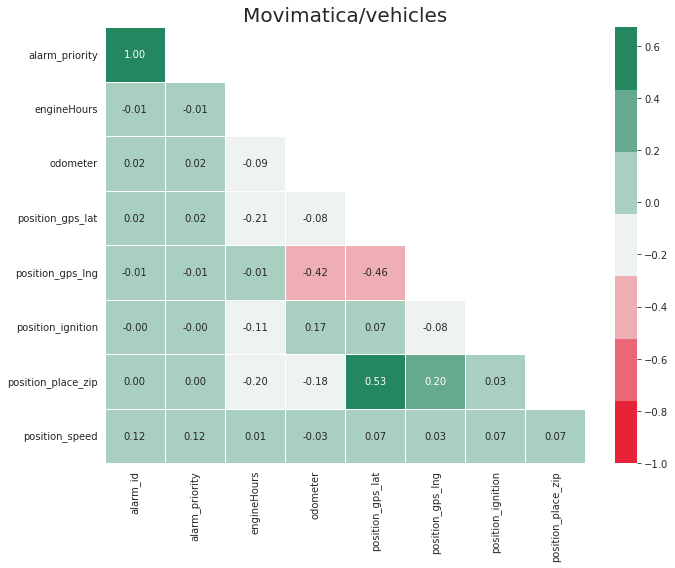

In [24]:
pseudo_plate = [c for c in df_MOV_vehicles.columns if len(df_MOV_vehicles[c].unique()) == 35]
correlations = df_MOV_vehicles.drop(pseudo_plate + ['position_id'], axis=1).corr()

fig, ax = plt.subplots(figsize=(10,8))
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
heatmap = sns.heatmap(correlations.iloc[1:,:-1], annot=True, fmt='.2f', linewidths=0.5,
            mask=mask[1:,:-1], ax=ax, cmap=sns.diverging_palette(10, 150, s=90, n=7),
            robust=True, vmin=-1)#, annot_kws={"size": 10})
plt.title("Movimatica/vehicles", size=20)
plt.tight_layout()
# fig.savefig("corr.png")

In [52]:
df_MOV_vehicles.columns

Index(['alarm_id', 'alarm_name', 'alarm_priority', 'alarm_tipology_id', 'box',
       'brand', 'chassis', 'engineHours', 'id', 'model', 'name', 'odometer',
       'plate', 'position_gps_lat', 'position_gps_lng', 'position_id',
       'position_ignition', 'position_place_address',
       'position_place_placeStr', 'position_place_state', 'position_place_zip',
       'position_speed', 'position_timestamp', 'position_typology_id',
       'position_typology_label', 'sav', 'filename', 'position_date'],
      dtype='object')

In [56]:
df_MOV_vehicles[['alarm_id', 'alarm_name', 'alarm_priority', 'alarm_tipology_id', 'position_typology_label']].drop_duplicates()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,position_typology_label
0,0,NaN,0,NONE,Cambio Digital IN
3,0,NaN,0,NONE,Alimentazione ripristinata
9,0,NaN,0,NONE,Anomalia
12,0,NaN,0,NONE,Fine movimento
58,0,NaN,0,NONE,Comunicazione
22,0,NaN,0,NONE,Stile di guida
44,0,NaN,0,NONE,Posizione
24,0,NaN,0,NONE,Inizio movimento
12,1861321,Alert Alternatore,4,ANOMALY,Fine movimento
9,1825143,Alert Alternatore,4,ANOMALY,Fine movimento


In [178]:
df_MOV_vehicles[['alarm_id', 'alarm_priority', 'alarm_name', 'alarm_tipology_id']].drop_duplicates()

,alarm_id,alarm_priority,alarm_name,alarm_tipology_id
119,0,0,NaN,NONE
5502,1861321,4,Alert Alternatore,ANOMALY
96328,1825143,4,Alert Alternatore,ANOMALY
72828,1665634,4,Alert Alternatore,ANOMALY
4719,1830776,4,Alert Alternatore,ANOMALY
18332,1862428,4,Alert Alternatore,ANOMALY
75003,1790271,4,Alert Alternatore,ANOMALY
64314,1863512,4,Alert Alternatore,ANOMALY
36357,1665633,4,Alert Alternatore,ANOMALY


---
## PCA

In [179]:
data_std.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')]).index

Index(['odometer', 'engineHours', 'position_speed', 'position_ignition'], dtype='object')

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# numerical_cols = df_MOV_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# numerical_cols = df_MOV_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# data_std = df_MOV_vehicles[numerical_cols[numerical_cols].index].drop(["id", "alarm_id"], axis=1)
data_std = df_MOV_vehicles[["odometer", "engineHours", "position_speed", "position_ignition"]].copy()

data_std[data_std.columns] = StandardScaler().fit_transform(data_std[data_std.columns])
data_std.head()

,odometer,engineHours,position_speed,position_ignition
119,-1.306122,-0.714378,-0.293483,-0.827088
35316,-1.306122,-0.714378,-0.293483,-0.827088
63045,0.927527,-0.852566,-0.293483,-0.827088
35269,1.773145,-0.711330,-0.293483,1.209062
35272,-0.963058,-0.809890,-0.151331,-0.827088


In [182]:
data_std = data_std.dropna()
pca = PCA(n_components=4)
pca.fit(data_std)
projection = pca.transform(data_std)

In [183]:
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.33576503, 0.25413525, 0.21557315, 0.19452656])

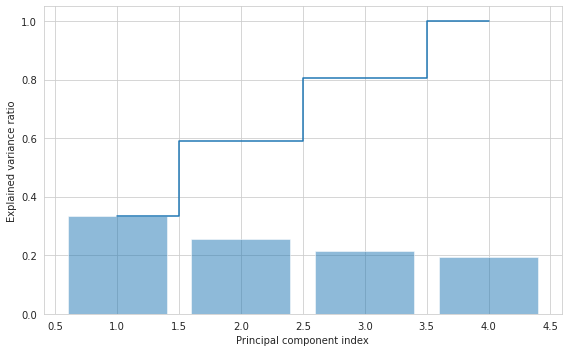

In [184]:
cum_sum_eigenvalues = np.cumsum(var_ratio)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_ratio) + 1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("PCA_6")
plt.show()

In [165]:
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(len(var_ratio))]

In [167]:
initial_feature_names = data_std.columns
most_important_names = {i: initial_feature_names[most_important[i]].to_list() for i in range(len(var_ratio))}

In [168]:
most_important_names

{0: ['odometer', 'position_place_zip', 'position_gps_lng'],
 1: ['position_gps_lng', 'engineHours', 'position_gps_lat'],
 2: ['position_gps_lng', 'position_ignition', 'position_gps_lat'],
 3: ['position_id', 'alarm_priority', 'position_speed'],
 4: ['engineHours', 'alarm_priority', 'position_id'],
 5: ['position_ignition', 'alarm_priority', 'position_speed']}

**position_place_zip??**